#### Course 

https://www.coursera.org/learn/deep-learning-in-computer-vision

In [1]:
from google.colab import drive
drive.mount('/content/drive') 
root_path = '/content/drive/My Drive/ML_DATA/face_keypoints/' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.

![title](example.png)

In [0]:
import os

os.chdir('/content/drive/My Drive/ML_DATA/face_keypoints/')

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [0]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [7]:
### Useful routines for preparing data
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import os
import numpy as np
import pandas as pd

def load_imgs_and_keypoints():
    images = []
    points = []

    co_ord = pd.read_csv(os.getcwd()+"/data/gt.csv")

    for index, row in co_ord.iterrows():
      
      if index%1000==0:
        print("Working on image number", index)

      image = imread(os.getcwd()+"/data/images/"+str(row["filename"]))
      if( len(image.shape)<3):
        image = gray2rgb(image)
      image_resized = resize(image, (100, 100),anti_aliasing=True)  
      images.append(image_resized)

      img_coord = list(row[1:])
      for i in range(0, len(img_coord), 2):
        img_coord[i] = img_coord[i]/image.shape[0] - 0.5
      for i in range(1, len(img_coord), 2):
        img_coord[i] = img_coord[i]/image.shape[1] - 0.5
      points.append(img_coord)


    return (np.array(images), np.array(points))

imgs, points = load_imgs_and_keypoints()

Working on image number 0
Working on image number 1000
Working on image number 2000
Working on image number 3000
Working on image number 4000
Working on image number 5000


In [8]:
imgs.shape

(6000, 100, 100, 3)

array([-0.27659574, -0.28723404, -0.11702128, -0.30851064,  0.10638298,
       -0.29787234,  0.35106383, -0.23404255, -0.25531915, -0.21276596,
       -0.13829787, -0.22340426, -0.07446809, -0.20212766,  0.12765957,
       -0.18085106,  0.22340426, -0.18085106,  0.32978723, -0.14893617,
       -0.04255319, -0.0106383 , -0.17021277,  0.14893617, -0.0212766 ,
        0.20212766,  0.13829787,  0.19148936])

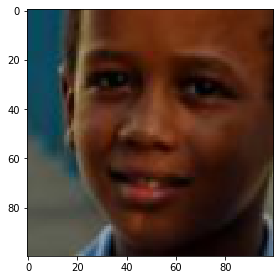

In [9]:
# output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[1])
points[1]

array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

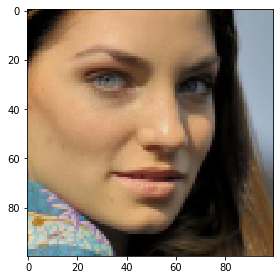

In [0]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

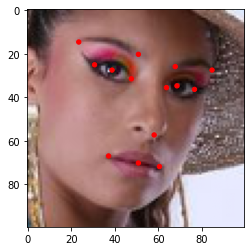

In [10]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    plt.imshow(img)

    for i in range(0, len(points), 2):
      plt.gcf().gca().add_artist(plt.Circle(((points[i]+0.5)*img.shape[0],(points[i+1]+0.5)*img.shape[1]),1,color='r'))

    plt.show()
    
visualize_points(imgs[3], points[3])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [0]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

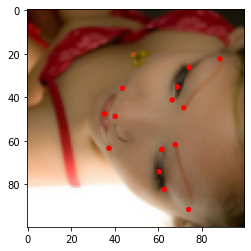

In [12]:
def flip_img(img, points):
  new_points = []

  for i in range(0, len(points), 2):
    old_x = (points[i]+0.5)*img.shape[0]

    flipped_x  = img.shape[0] - old_x -1

    new_points.append((flipped_x/img.shape[0]) - 0.5)
    new_points.append(points[i+1])

  return (img.copy()[:, ::-1], new_points)

f_img, f_points = flip_img(imgs[10], points[10])
visualize_points(f_img, f_points)

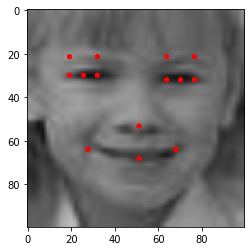

In [13]:
visualize_points(imgs_train[0], points_train[0])

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [0]:
aug_imgs_train = []
aug_points_train = []

for i in range(len(imgs_train)):
  f_img, f_points = flip_img(imgs_train[i], points_train[i])
  aug_imgs_train.append(imgs_train[i])
  aug_points_train.append(points_train[i])
  aug_imgs_train.append(f_img)
  aug_points_train.append(f_points)

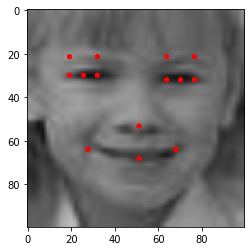

In [15]:
visualize_points(aug_imgs_train[0], aug_points_train[0])

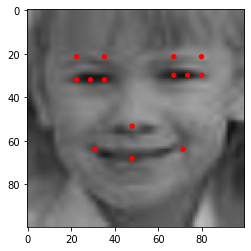

In [16]:
visualize_points(aug_imgs_train[1], aug_points_train[1])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [17]:
# from keras.models import Sequential
# from keras.layers import (
#     Conv2D, MaxPooling2D, Flatten,
#     Dense, Dropout
# )

# model = Sequential()
# Define here your model

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.metrics import MeanSquaredError

img_shape = (100, 100, 3)

model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
for layer in model_vgg16_conv.layers:
  layer.trainable= False
    #model_vgg16_conv.summary()
    
    #Create your own input format
keras_input = Input(shape=img_shape, name = 'image_input')
    
    #Use the generated model 
output_vgg16_conv = model_vgg16_conv(keras_input)
    
    #Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dropout(0.2)(x)
x = Dense(28, activation='tanh', name='output')(x)

    
    #Create your own model 
pretrained_model = Model(inputs=keras_input, outputs=x)
pretrained_model.summary()

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 100, 100, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               2359808   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 128)               65664     
____________________________________________________________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [19]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info

# Choose optimizer, compile model and run training
pretrained_model.compile(loss='mse', optimizer='adam', metrics=[MeanSquaredError()])

pretrained_model.fit(np.array(aug_imgs_train), np.array(aug_points_train), validation_data=[np.array(imgs_val), np.array(points_val)], epochs = 5, batch_size=128)

Train on 10800 samples, validate on 600 samples
Epoch 1/5
10800/10800 [==============================] - 35s 3ms/step - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 2/5
10800/10800 [==============================] - 24s 2ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 3/5
10800/10800 [==============================] - 24s 2ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 4/5
10800/10800 [==============================] - 24s 2ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 5/5
10800/10800 [==============================] - 24s 2ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0169 - val_mean_squared_error: 0.0169


### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [23]:
np.expand_dims(imgs_val[10], axis=0).shape

(1, 100, 100, 3)

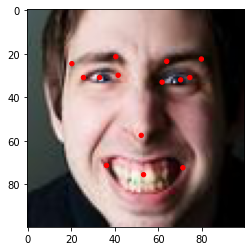

In [26]:
# Example of output
predicted_points = pretrained_model.predict(np.array(np.expand_dims(imgs_val[100], axis=0)))

visualize_points(imgs_val[100], points_val[100])
